
# Habilidades Mostradas 

Este anaisis se ve :
  * Menejo de missings
  * Manipulacion de datos
  * Elaboracion de estadisticas descriptivas
  * Feature enginering y selection en data set desbalanceados. 
  * Aplicacion de algoritmos de aprendizaje supervisado
  * Hiperparameter tuning y model validation 

El analisis es basado en Python y las siguientes librerias se usaron

✅ Manejo de datos : Numpy, Pandas, skitlearn.resample , imblearn.over_sampling.

✅ Visualizacion de datos : Seaborn and Matplotlib.

✅ Tecnicas de aprendizaje supervizado: Sklearn, imblern.pipeline




# Resumen Ejecutivo

El objetivo de este trabajo es el desarrollo de un modelo predictivo para saber si un cliente va a realizar o no un deposito a plazo en un banco. Es un problema de aprendizaje supervisado, ya que el objetivo es predecir una respuesta etiquetada (El cliente adquiere o no el producto) a partir de una serie de datos. Una particularidad de este data set es que no balanceado, por lo tanto se deben tomar medidas correctivas. Los pasos a seguir consistieron:
  * Importacion de librerias y manejo de los datos
  * Analisis descriptivo de las variables. Visualmente parecería que hay cierta estacionalidad del producto, en particular los meses Septiembre, Octubre, Diciembre, así como tambíen en Marzo. Además el medio de contacto importa, como tambíen el resultado de la campaña de marketing anterior. 
  * Manipulacion de datos y features enginering para dejar el data set listo para los modelos de Machine Learning. Esto implico obtener las variables dummys de las categoricas, dividir el data set en un grid set y validation set y estandarizar ambos data set.
  * Se realizo un proceso de feature seleccion, para esto se utilizo una tecnina conocida como recursive feature elimination, junto con un cross validation que permite a la vez identificar no solo las mejores caracteristicas sino tambien el numero optimo de estas. Previamente, los data set fueron balanceados a traves de up-sampling. Los modelos usados para elegir las caracteristicas fueron Logistic Regression, Gradient Boosting y Random Forest con hiperparametros por default de ScikitLearn y se opto por utilizar aquellas features que habían sido incluidas por los 3 modelos. 
  * Finalmente se realizo un proceso de seleccion de hiperparametros a traves de cross validation con GridSearCV. Para balancear los data set se utilizo una tecnica conocida como SMOTE. Los modelos a considerar nuevamente fueron Logistic Regression, Gradient Boosting y Random Forest.

Con todo esto se eligio el modelo segun sú performance en Recall, siendo este Logistic Regression que obtuvo un puntaje de 60%. 

# Primeros pasos
  1. Importacion de librerias
  2. Corregir tipos de datos 

In [225]:
#Importamos librerías que vamos a usar en el codigo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#Funciones especificas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold , KFold , GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils import resample 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC, RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve,  confusion_matrix, precision_score , recall_score, precision_recall_curve, classification_report


from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE , SMOTENC

#Option setup de graficos y pandas
pd.set_option("display.max_columns", None)
plt.style.use('seaborn-pastel')

In [3]:
#Cargamos dataset y lo vemos si esta cargado correctamente las variables y los missings.
banco = pd.read_csv('raw_data/bank-additional-full (2).csv', 
                    delimiter = ';')
banco.drop(columns= ['duration'], inplace= True) 
#Como usamos modelo para fines predictivos no cargamos la columna durations como aconseja informacion del dataset.
banco.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [4]:
cat = ['job' , 'marital' , 'education' , 'default' , 'housing' , 'loan' , 'contact' , 'month' , 'day_of_week', 'poutcome']
numeric = ['age' , 'campaign', 'pdays', 'previous' , 'emp.var.rate','cons.price.idx', 'cons.conf.idx' , 'euribor3m' , 'nr.employed']
output = ['y']

banco[cat + output] = banco[cat + output].astype('category') 
#convertimos las variables categoricas en categorias. 


### Manejando los missings 

Por documentacion vemos que los missings en las variables categoricas son clasificadas como 'unkwon' 

Las demas variables no tienen missings, pero la variable pdays tiene un valor de 999 si el cliente nunca fue contactado con anterioridad. La decisión tomada es hacerla categorica cuando se realice el feature enginnering

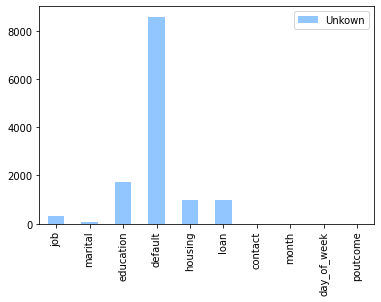

In [5]:
#Contamos y graficamos la cantidad de Unknown que hay por columna
unknown = {}
for i in cat:
    count = banco[i].value_counts()
    lcount = list(count.index)
    if 'unknown' in lcount:
        unknown[i] = count.loc['unknown']
    else:
        unknown[i] = 0
unknown = pd.DataFrame.from_dict(unknown, 
                                 orient='index', 
                                 columns= ['Unkown'])
unknown.plot.bar()
plt.show()


En la unica variable que los missin parecen ser problematicos es en default, veamos como se ve cuando divimos cada categoria por dentro 

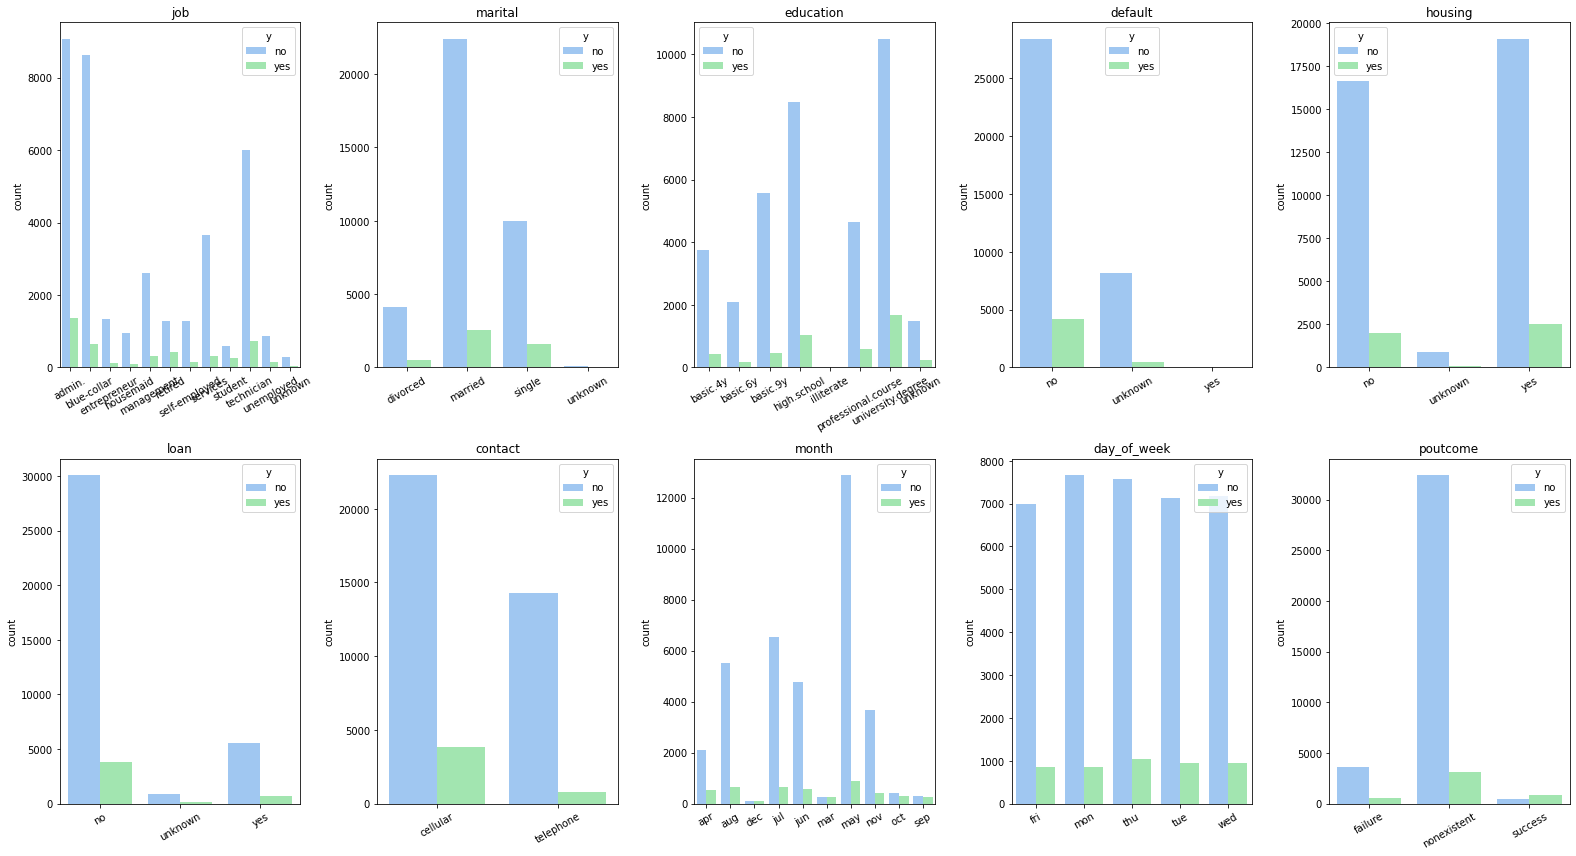

In [6]:
plt.figure(figsize = (22,12))

for idx,col in enumerate(cat):
    plt.subplot(2, 5 , idx + 1)
    sns.countplot(x= col, hue = 'y' , data = banco)
    plt.xticks(rotation=30)
    plt.xlabel('')
    plt.title(col)

plt.tight_layout()

En la unica variable que los valores desconocidos son un problema es en Default.Como el dataset no contiene valores positivos para esa variable es decir los clientes o bien no respondieron la pregunta o no entraron en default vamos a eliminar la variable Default. Ademas, vamos a descartar las filas con valores desconocidos para las demas variables

In [7]:
banco_l = banco.drop(columns='default')
banco_l.replace('unknown' , np.nan, inplace= True)
banco_l.dropna(inplace= True)
cat.remove('default')



# Analisis Exploratorio y descriptivo. 




## Variables Numericas


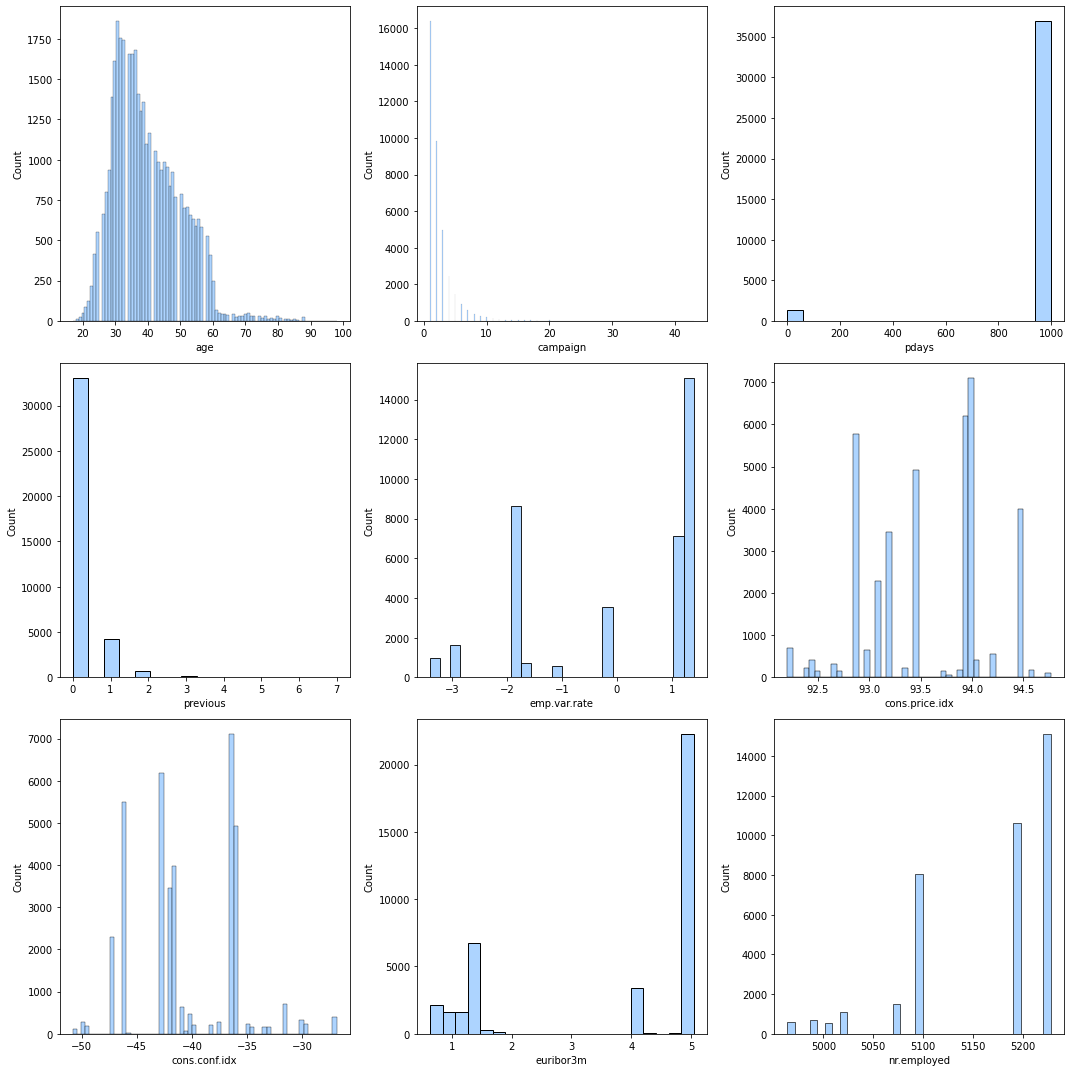

In [8]:
plt.figure(figsize= (15,15))
for i,c in enumerate(numeric):
    plt.subplot(3,3, i+1); sns.histplot(x= c , data= banco_l)
plt.tight_layout()    


Salvo edad las variables no suelen seguir una distribucion normal a lo largo del data set, lo que se va a hacer es aplicar una transformación logaritmica para mejorar las propiedades de su distribución.


## Variables Objetivo. 

In [9]:
#Funcion
def stack_barplot(df , columna , hue = 'y' , a = None):
    """Devuelve un grafico de barras apilado con el porcentaje 
    de participacion entre si y no en la muestra. 
    """
    #Con pct obtengo la fraccion de positivos y negativos dentro del total
    pct = df.groupby([columna , hue]).age.count() \
        / df.groupby([columna]).age.count()

    if a == None :
        pct.unstack().plot.bar(stacked = True)
    else: 
        pct.unstack().plot.bar(stacked = True, 
                               ax = a,
                               title = columna.upper(),
                               legend = False,
                               rot = 90,
                               ylabel = '%',
                               xlabel = '')

    
        

   


Text(0, 0.5, '')

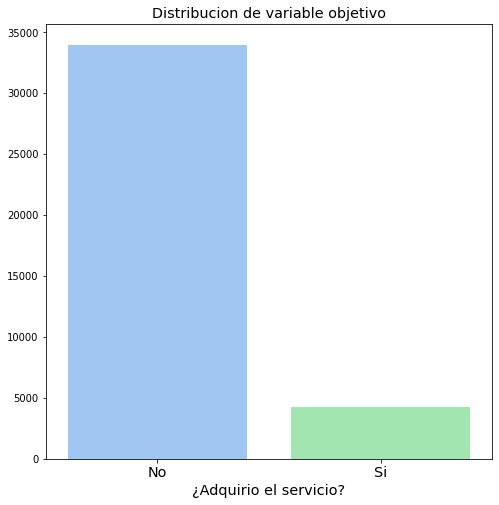

In [10]:

plt.figure(figsize=(8,8))
a = sns.countplot(x= 'y' ,
              data = banco_l,
              order = ['no' , 'yes'])
plt.title('Distribucion de variable objetivo', fontsize = 'x-large')
plt.xlabel('¿Adquirio el servicio?' , fontsize = 'x-large')
plt.xticks(ticks = a.get_xticks(), labels = ['No' , 'Si'], fontsize = 'x-large')
plt.ylabel('')

El dataset no es balanceado. Esto quiere decir que los casos donde la variable es positiva son mucho menores a los casos en los cuales la variable objetivo es negativa. Mucho de los algoritmos de machine learning requieren que el dataset sea balanceado, por lo que más adelante se procedera a balancearlo 'artificialmente'.

Text(0.3, 0.93, 'Graficos de 100% Barra agrupadas')

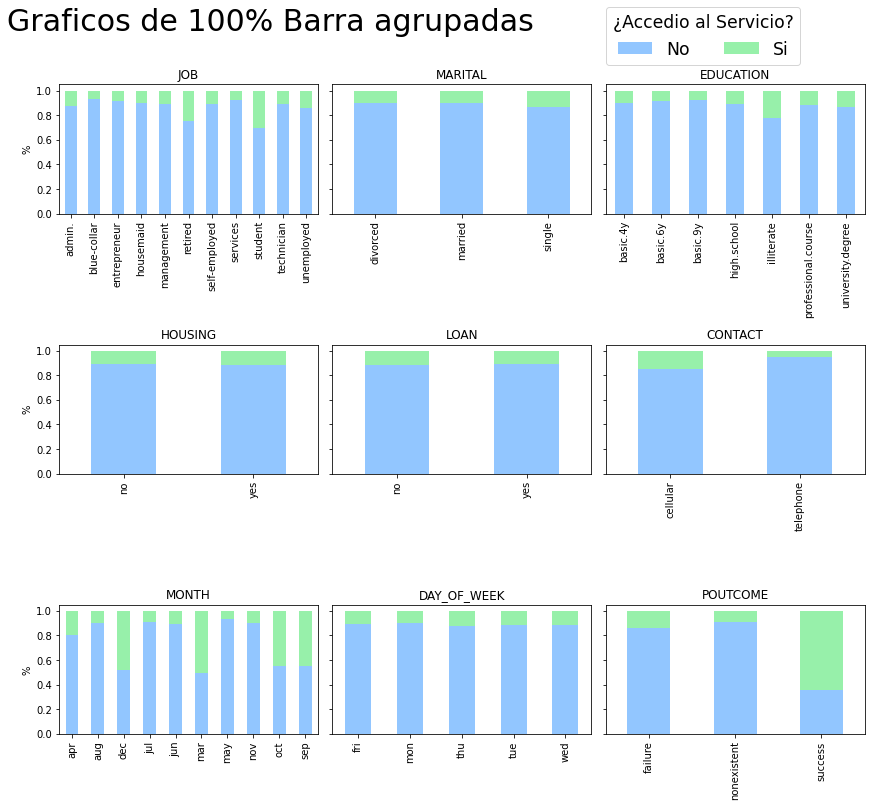

In [11]:
fig, axs = plt.subplots(3,3, 
                        sharey= True,
                        figsize = (12,12),
                        tight_layout = True)
for idx,col in enumerate(cat):
    stack_barplot(banco_l , col, 
                  a = axs.flatten()[idx]) #Flatten se usa para hacer el array de varias dimensiones a 1

axs.flatten()[2].legend(loc = (0, 1.15) ,     
                        fontsize = 'xx-large',
                        ncol = 2,
                        labels = ['No' , 'Si'],
                        title = '¿Accedio al Servicio?',
                        title_fontsize = 'xx-large')
fig.suptitle('Graficos de 100% Barra agrupadas', 
             fontsize = 30,
             x = 0.3,
             y =0.93)
    


Entre las profesiones con más porcentaje de adquisisión del producto se encuentran los retirados y los estudiantes. Por otro lado se obtiene un gran porcentaje de adquisición del servicio en los iletrados. El producto parece ser estacional con fuertes ratios de adquision en Septiembre, Octubre, Diciembre, así como tambíen en Marzo. El medio de contacto parace tener cierta influencia, siendo mas probable que el cliente adquiera el producto si es contactado por celular. Finalmente, si la campaña previa de marketing fue exitosa, es altamente probable que el cliente adquiera el producto. 
No se verifican diferencias significtivas respecto a la adquisición o no del producto cuando observamos el estado marital, si tiene un credito hipotecario, si ya tiene un credito personal o dependiendo el dia de la semana. 

In [12]:
#Creamos un dataset para ver ciertas estadisticas descriptivas dependiendo de si adquirieron o no el producto. 
df_si = banco_l.where(banco_l.y =='yes')
df_no =banco_l.where(banco_l.y == 'no')

describe = banco_l.groupby('y').agg(['mean' , 'std']).T
print('--Medias y desviós standares para las variables númericas segun si adquirieron o no el producto--')
describe

--Medias y desviós standares para las variables númericas segun si adquirieron o no el producto--


y                             no          yes
age            mean    39.751140    40.736731
               std      9.813267    13.470872
campaign       mean     2.630447     2.057539
               std      2.870559     1.651937
pdays          mean   984.363286   797.255284
               std    119.664719   399.614192
previous       mean     0.131874     0.474401
               std      0.406537     0.841672
emp.var.rate   mean     0.244852    -1.210146
               std      1.480120     1.630373
cons.price.idx mean    93.597463    93.353607
               std      0.556825     0.675437
cons.conf.idx  mean   -40.625313   -39.869493
               std      4.387415     6.150843
euribor3m      mean     3.807377     2.153996
               std      1.637131     1.751342
nr.employed    mean  5176.267270  5096.914702
               std     64.284061    87.600118

Text(0.5, 0.93, 'Boxplots de variables numericas detallando si adquirieron o no el producto')

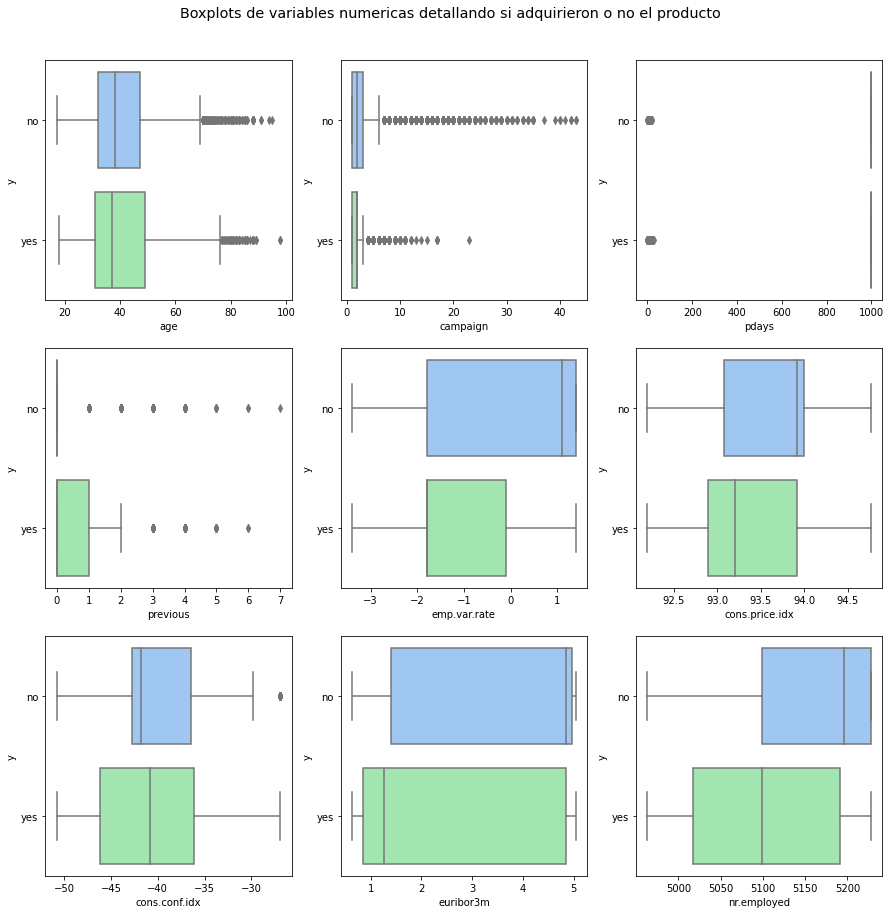

In [13]:
fig = plt.figure(figsize = (15,15))
for i,c in enumerate(numeric):
    plt.subplot(3,3, i+1)
    sns.boxplot(x= c , y ='y' , data= banco_l)
fig.suptitle('Boxplots de variables numericas detallando si adquirieron o no el producto' ,
             fontsize = 'x-large',
             y = 0.93)


Se puede observar que las edades son parecidas tanto para personas que adquieren el producto como para las que no. Aquellos que adquieren el producto tienden a tener una mayor cantidad de contactos. La subscripcion de un deposito a plazo se relaciona con un aumento del desempleo, es decir con una variacion negativa. 


# Feature enginering y data preprocessing 

En esta seccion vamos a realizar feature enginering y data preprocessing para dejar las variables listas para trabajar en modelos de machine learning.
1. Hacer categorica la variable pdays. 
2. Obtener las dummys para cada variable categorica
3. Creamos dataset X e y
4. Partir el Dataset en un train set y un validation set. 
5. Aplicamos logaritmo a las variables numericas
6. Estandarizar el datset para que todas las variables tengan la misma media y desvio standard. 
7. Guardamos la data en un CSV.

Muchos de los modelos de Machine Learning,en especial aquellos no parametricos, descansan en alguna medida de distancia para tomar decisiones o exigen
que las variables tengan distribuciones normales o similares.  Es por eso que realizamos los pasos 5 y 6. 

Por otro lado, debemos 






##### 1.Haciendo categorica pdays

In [14]:
cut = [0,5,10,20,40,100, np.inf]
labels = ['0-5_d' , '5-10_d' , '10-20_d' , '20-40_d', '40-100_d' ,'no_contact']  
#asumimos que mas alla de 100 dias del ultimo contacto es como si contara

banco_l['pdays_cat'] = pd.cut(banco_l.pdays , 
                              bins = cut ,
                              labels= labels)

cat.append('pdays_cat')
numeric.remove('pdays')
banco_l = banco_l.drop(columns= 'pdays')


##### 2. Obteniendo variables dummys.

In [15]:
dataset_dummy = pd.get_dummies(data = banco_l, 
                               drop_first= True, 
                               columns= cat + output)

dataset_dummy.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,pdays_cat_5-10_d,pdays_cat_10-20_d,pdays_cat_20-40_d,pdays_cat_40-100_d,pdays_cat_no_contact,y_yes
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0



##### 3. Creamos data set X e Y



In [16]:
X_d = dataset_dummy.drop(columns= 'y_yes')
y = dataset_dummy['y_yes']


##### 4. Dividimos el data set en X_grid, y_grid y X_val, y val

In [17]:
X_grid_d , X_val_d , y_grid, y_val = train_test_split(X_d,
                                                  y, 
                                                  test_size= 0.15 , 
                                                  random_state= 0,
                                                  #Ramdm_state para garantizar reproducibilidad
                                                  stratify= y)

##### 5. Aplicamos logaritmo a las variables numericas. 

In [18]:
def log_transformation(data, col_log) : 
    """Le damos un data set y lista de columnas a aplicar una transformacion log
    Le suma el minimo a cada columna y 1 para hacer todos positivos"""
    X = data.copy()
    for c in col_log:
        X[c] = np.log( X[c] + 1 + abs(X[c].min()))
    return X 
                      
X_grid_d_l = log_transformation(X_grid_d, numeric)
X_val_d_l = log_transformation(X_val_d, numeric)
    
    


##### 6. Estandarizamos el dataset 

Estandarizar variables dummys tiene en sentido en terminos de mayor capacidad de prediccion del modelo, no así en terminos de interpretabilidad. Como nuestro objetivo es la prediccion, entonces standarizamos todo. 
Por ultimo, debemos estandarizar todo con la data que 'conocemos' y no con la de validation. De lo contrario, estariamos incluyendo informacion que la realidad no tendriamos si estuvieramos viendo como funciona el modelo. 

In [41]:
#Inicializamos el standard Scaler y lo fiteamos
std = StandardScaler()
std.fit(X_grid_d_l)
#Creamos unos numpy array temporales 
grid_temp= std.transform(X_grid_d_l)
val_temp = std.transform(X_val_d_l)

#Guardamos los datos como DF
X_grid_d_l_e = pd.DataFrame(data = grid_temp , index = X_grid_d_l.index , columns= X_grid_d_l.columns)
X_val_d_l_e = pd.DataFrame(data = val_temp , index = X_val_d_l.index , columns= X_val_d_l.columns)

##### Guardamos la data procesada en CSV 

In [42]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

files = [X_grid_d_l_e , X_val_d_l_e , y_grid , y_val]
for file in files:
    file_name = get_df_name(file)
    file.to_csv(f'process_data/{file_name}.csv',
                index_label= 'index')




# Feature selection 

En este paso lo que vamos a intentar es quedarnos con aquellas variables que aporten capacidad explicativa al modelo. En los modelos de Machine Learning es importante disminuir 
la cantidad de variables que se usan. Muchas variables pueden hacer que el modelo sobreajuste(overfiting) generando que se encuentren relaciones donde no las hay. Los pasos a seguir son:

1. Se realiza un upsampleo para equilibrar las muestras de la variable objetivo. Si bien mas adelante vamos a utilizar SMOTE, inicialmente no es recomendable utilizarlo para muestras con muchos features.
2. Vamos a utilizar Recursive Feature Elimination para en un modelo logistico para reducir las features. 
3. Identico al paso 2 pero con RandomForestClassifier
4. Identico al paso 2 pero con GradientBoostingClassifier.
5. Vamos a seleccion aquellas Features que hayan sido elegidas por los 3 modelos. 

In [43]:
#Leemos los data set que guardamos 

X_g_fs = pd.read_csv('process_data/X_grid_d_l_e.csv', index_col= 'index')
X_v_fs = pd.read_csv('process_data/X_val_d_l_e.csv', index_col= 'index')
y_g_fs = pd.read_csv('process_data/y_grid.csv', index_col = 'index' )
y_v_fs = pd.read_csv('process_data/y_val.csv', index_col= 'index')

##### 1. Upsampleo
Consiste en tomar muestra con repeticion de la categoria minoritaria, equilibrando el data set. Tiene el problema de que puede llevar a overfiting, no obstante, es mejor que SMOTE en ambientes con altas dimesiones. 


In [44]:
def upsample( X, y, feature_col):
    """ Damos un feature data set y target data set y nos devulve una muestra balanceada"""
    #Unimos horizontalmente el data set para incoporar la columna target
    data = pd.concat([X, y] , axis =1)   
    #Dividimos la muestra en la categoria mayoritaria y minorita 
    data_mayoria = data[data[feature_col] == 0] 
    data_minoria = data[data[feature_col] == 1]
    data_min_up = resample(data_minoria, replace = True , n_samples= len(data_mayoria)) 
    #Unimos la muestra verticalmente ( Ahora data_min_up tiene las mismas columnas)
    data_up = pd.concat([data_mayoria , data_min_up] , axis = 0)
    X_data = data_up.drop(columns = [feature_col], axis = 1)
    y_data = data_up[[feature_col]]
    #Chequeo 
    assert y_data[feature_col].value_counts()[0] == y_data[feature_col].value_counts()[1]
    return X_data, y_data

#Realizamos el upsampleo 
X_g_fs_up, y_g_fs_up = upsample(X_g_fs , y_g_fs ,'y_yes')
X_v_fs_up , y_v_fs_up = upsample(X_v_fs , y_v_fs, 'y_yes')


##### 2. a) Creamos la funcion : CVRSE

Vamos a utilizar una tecnica que se llama Recursive Feature Elimination(RSE) junto con Cross validation,
de esta forma podemos allar a la vez las features que mas informacion aportan así como el numero optimos de 
features para el modelo. Se parte de un modelo completo al cual se le ejecuta un cross validation( es decir se divide el data set en K partes y se entrena en K-1 y se testea en la restante), luego se elimina la feature con menos capacidad de explicacion. Esto es realizado hasta que se alcanza un numero minimimo de features o porque quedo una sola feature. Para finalizar se optiene que feature tuvo el mejor desempeno. 

In [110]:
model_caracteristics = list()
features = list()
def cv_rfe( model, clf, X, y, X_test, y_test , min_fea = 1) :
    """ Pasamos un modelo clasificador y realize un RFECE para determinar
    el numero optimo de variables.
    Devuelve un diccionario con caracteristicas del modelo y otro con 
    las variables seleccionadas. 

    Args:
        model (str): [description]
        clf (Clasificador): tiene que tener feature_importance_
        X : Train data set 
        y : Train target 
        X_test : Test data set 
        y_test : Test target
        min_fea (int, optional): Minimas features q corrobora el modelo Defaults to 1.

    Returns:
        [type]: [description]
    """
    np.random.seed(0)
    min_features_to_select = min_fea 
    rfecv = RFECV( estimator = clf,
                 step = 1, 
                 min_features_to_select = min_features_to_select,
                 cv = StratifiedKFold(5 ,shuffle = True, random_state = 0),
                 scoring = 'accuracy')
    
    rfecv.fit(X,y)
    
     
    #Datos que necesito devolver 
    
    score = rfecv.cv_results_['mean_test_score'].max()
    optimal = rfecv.n_features_
    features = rfecv.support_
    test_score = rfecv.score(X_test, y_test)
    #Graficando resultado
    
    plt.figure(figsize =(8,8))
    plt.xlabel('Numero de features seleccionadas')
    plt.ylabel('Accuracy')
    plt.plot(range(min_features_to_select , len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
             rfecv.cv_results_['mean_test_score'] , label = 'Test_score')
    plt.plot(range(min_features_to_select , len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
             rfecv.cv_results_['mean_test_score'] , label = 'Test_score')
    plt.annotate(f'Numero optimo de features :{optimal} \n Accuracy : {score}',
                 xy=(optimal, score),
                 fontsize = 12,
                 arrowprops=dict(facecolor ='red',
                                shrink=0.5))
    plt.show()
   
    print('{0} puede explicar {1:.1%} de la varianza del test set'.format(model, test_score))
    
    
    
    
    
    return { 'Model' :model, 
            'Recall' : score,
            'n_features': optimal}, \
           {'Model' : model, 
           'Feature' : features}

##### 2.b) Corremos el modelo Logistico. 

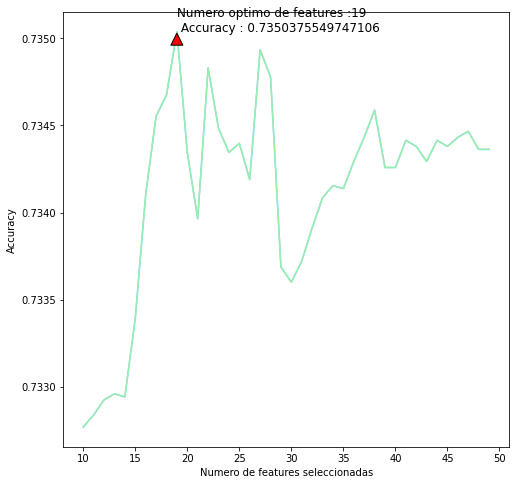

Logistic Regression puede explicar 72.1% de la varianza del test set


In [111]:
lr_caracteristics, lr_features = cv_rfe('Logistic Regression', 
                                        LogisticRegression(random_state = 0),
                                        X_g_fs_up, 
                                        y_g_fs_up['y_yes'], 
                                        X_v_fs_up, 
                                        y_v_fs_up['y_yes'],
                                        min_fea =10)
model_caracteristics.append(lr_caracteristics)
features.append(lr_features)

##### 3. Corremos el modelo de Random Forest

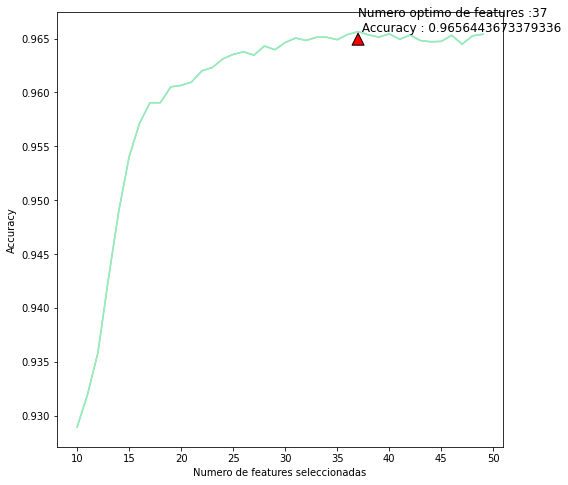

RFC puede explicar 64.3% de la varianza del test set


In [117]:
#Corremos el modelo de ramdon forest para elegir las features. 
rfc_caracteristics, rfc_features = cv_rfe('RFC', 
                                          RFC(random_state = 0), 
                                          X_g_fs_up, 
                                          y_g_fs_up['y_yes'], 
                                          X_v_fs_up,
                                          y_v_fs_up['y_yes'],
                                          min_fea =10)
model_caracteristics.append(rfc_caracteristics)
features.append(rfc_features)

##### 4. Corremos el modelo de Gradient Boosting Classifier.

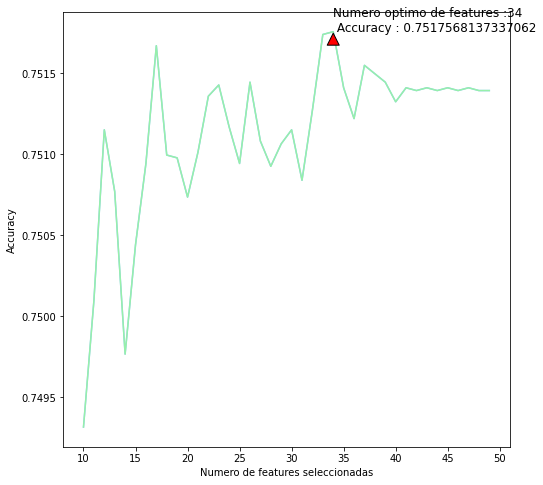

GBC puede explicar 73.0% de la varianza del test set


In [118]:
#Corremos el modelo de gradient boosting para elegir las features. 
gbc_caracteristics, gbc_features = cv_rfe('GBC', 
                                          GBC(random_state = 0), 
                                          X_g_fs_up,
                                          y_g_fs_up['y_yes'], 
                                          X_v_fs_up,
                                          y_v_fs_up['y_yes'],
                                          min_fea =10)
model_caracteristics.append(gbc_caracteristics)
features.append(gbc_features)


Podemos ver que la regresion logistica fue la que menos caracteristicas del data set selecciono(19), mientras que Gradient Boosting y Random Forest seleccionaron caracteristicas similares. De todos modos, Random Forest presenta cierta evidencia de overfiteo (Score muy alto en el training set, pero muy bajo en el Test data set).

In [119]:
features_df = pd.DataFrame(features)
model_catacteristics_df = pd.DataFrame(model_caracteristics)

features_df.to_csv('process_data/features_df.csv',
                index_label= 'index')
model_catacteristics_df.to_csv('process_data/model_ca.csv',
                index_label= 'index')

##### 5. Seleccionamos las features

Para hacer eso realizamos una votación y nos quedamos con aquellas características que hallan sido elegidas por los 3 modelos.

Este paso es un tanto arbitrario y podriamos haber considerado como benchmark 2 al menos dos modelos las hubiesen elegido.


In [136]:
votos = sum([features_df.iloc[i, 1] for i in range(3)])
mask = votos > 2
print(f"---- Cantidad de features elegidas {sum(mask)} ----")
print(X_g_fs.columns[mask])

---- Cantidad de features elegidas 15 ----
Index(['campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'nr.employed',
       'job_retired', 'education_basic.9y', 'education_professional.course',
       'education_university.degree', 'contact_telephone', 'month_may',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success',
       'pdays_cat_no_contact'],
      dtype='object')



# MODELADO

Para el modelado se van a seguir los siguientes pasos:

1- Desarrollo de funciones cv_model_selection y caracteristicas_modelo. La primera realiza un pipeline donde se balancea el data set y se aplica el clasificador, esta pipelin es pasada hacia un GridSearchCV o RandomSearCV que nos permite a traves de cross validation elegir los mejores hiperparametros para el modelo. La segunda funcion nos va a servir para ver las caracterisiticas del modelo elegido, como puede ser una roc_curve, una tabla con los valores de accuracy, recall, F1 , una confusion matrix  y una curva recall-precision.

2)Se utiliza la funcion cv_model_selecction junto con los hiperparametros correspondiente para :
    
  1. Regresion Logistica

  2. RandomForest Classification
   
  3. GradientBoosting 

Funciones importantes:

  * StratifiedKFold : Permite dividir el data set en un train y test set mientras se realiza la GRIDSEARCH CV. Lo que esta bueno es que intenta replicar la proporcion real de cada categoría y evitar que queden pocas en alguno de los dos data set.
    
  * SMOTENC / SMOTE : Permite balancear los data set. Lo que hace es upsamplear la categoria minoritaria creado 'muestras artificiales pero factibles'. Para hacer esto utiliza el algoritmo KNN y toma la media de sus caracteristicas mas ruido. Aclaracion LO mas adecuado tecnicamente es aplicar SMOTENC en vez de SMOTE, ya que permite la incorporacion de variables categoricas, pero increamentaba significativamente el tiempo de ejecucion del modelo. 





In [209]:
%% capture 
cat_reduce = [5,6,7,8,9,10,11,12,13,14]
#CARGAMOS los data set antes de upsamplear. 
X_g= pd.read_csv('process_data/X_grid_d_l_e.csv', index_col= 'index')
X_v = pd.read_csv('process_data/X_val_d_l_e.csv', index_col= 'index')
y_g = pd.read_csv('process_data/y_grid.csv', index_col = 'index' )
y_v = pd.read_csv('process_data/y_val.csv', index_col= 'index')

X_g_reduce = X_g.iloc[:,mask]
# X_g_reduce.iloc[ :, cat_reduce] = X_grid_d_l.iloc[: , mask].iloc[:, cat_reduce] #Desestandarizamos la dummys (opcional)

X_v_reduce = X_v.iloc[: ,mask]
# X_v_reduce.iloc[ :, cat_reduce] = X_val_d_l.iloc[: , mask].iloc[:, cat_reduce]  #Desestandrizamos la dummys (opcional)

UsageError: Cell magic `%%` not found.


In [231]:
#### PIPELINES para elegir modelo y graficas estandares para evaluarlo.  


def cv_model_selection(model, clf, params  , X_train , y_train  , X_test  , y_test , cat_reduce = cat_reduce, full_search = False):
    """Realiza un GridSearch CV para un modelo predictivo. Primero balancea el dataset con SMOTENC / SMOTE y luego corre el modelo indicado.
    Finalmente guarda el modelo obtenido.
    Args:
        model ([str]): Nombre del modelo 
        clf ([type]): Clasificador 
        cat_reduce ([list], optional): Lista con las variables categoricas. Defaults to cat_reduce.
        params ([dict]): Diccionario para GridSearchCV. Defaults to new_params.
        X_train ([type]): Data set para entrenar el modelo Defaults to X_train_reduce.
        y_train ([type]): Target variable para entrenar. Defaults to y_train.
        X_test ([type]): Data set para testear el modelo . Defaults to X_test_reduce.
        y_test ([type]): Target para testear el modelo. Defaults to y_test.
        full_search ([bool])

    Returns:
        gs_clf : Modelo optenido
        Diccionario con caracteristicas del modelo. 
    """
    np.random.seed(0)   #Ponemos una semilla 
    
    kf =StratifiedKFold(shuffle = True)   #Usamos Stratifie Kfolds para seleccionar el test set 
    
    #smote = SMOTENC(categorical_features = cat_reduce)
    
    smote = SMOTE()
    pipe = make_pipeline(smote , 
                         clf)
    if full_search == True:
        #CREAMOS el grid search CV para seleccionar los mejores parameros
        gs_clf = GridSearchCV(pipe, 
                              param_grid = params ,
                              cv = kf ,  
                              scoring ='roc_auc')
    if full_search == False:
        #Podemos usar RandominizedSearch
        gs_clf = RandomizedSearchCV(pipe, 
                              param_distributions = params ,
                              cv = kf ,  
                              scoring ='roc_auc',
                              n_iter= 9)
   
    #Fiteamos 
    
    gs_clf.fit(X_train , y_train )
    
    #Usamos el mejor modelo para predecir
    y_test_predict = gs_clf.best_estimator_.predict(X_test)
    score = roc_auc_score(y_test , y_test_predict)
    
    #Salvamos el mejor modelo
    file = f'models/{model}.pkl'
    with open(file , 'wb') as file:
        pickle.dump(model, file)
    
   
    return gs_clf, {'Modelo' : model , 'Mejor Hyperparametro' : gs_clf.best_params_ , 'AUC' : round(score,5)} 
    


def caracteristicas_modelo(model , clf , X_test , y_test):
    """Funciones graficas standares para evaluar modelo clasificatorio
        
        Devuelve un diccionaro
    """
    #Valores para evluar el modelo
    
    y_test_pred = clf.predict(X_test)
    auc = roc_auc_score(y_test , y_test_pred)
    precision = precision_score(y_test , y_test_pred)
    recall = recall_score(y_test , y_test_pred)
    accuracy = clf.score(X_test  , y_test )
    
    # Reporte de Clasificacion
    print(f'{model} - Classification report ==')
    print( classification_report( y_test , y_test_pred))
    

    
    # Grafica de confusion Matrix 
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # Creando heatmap para la confusion matrix.
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'{model}- Confusion matrix', y=1.1)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')   
    plt.show()
    
    # Plot ROC curve
    # Calcular las probabilidades predichas
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    # Generar valores para la curva 
    fpr, tpr, thresholds= roc_curve(y_test, y_pred_prob)
    # Graficar
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.plot(fpr, tpr, marker='.', label=model)
    plt.xlabel('Ratio de falsos positivos')
    plt.ylabel('Ratio de falsos negativos')
    plt.title(f'{model} - ROC curve')
    plt.annotate(f'AUC ={round(auc, 5)} ', xy=(0.7, 0.5),fontsize=12,)
    # show the legend
    plt.legend()    
    plt.show()
    
    
    # Graficamos precision recall curve 
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred_prob)
    
    # Un classificador random es el que predice de forma aleatoria 
    random_clf = y_test[y_test==1].count() / len(y_test) #len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [random_clf, random_clf], linestyle='--', label='Precision promedio.')
    plt.plot(recall_, precision_, marker='.', label=model)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model} - Curva de precision y recall')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    return {'Modelo':model, \
            'Accuracy': round(accuracy,5) , \
            'Precision':round(precision,5) , \
            'Recall':round(recall,5), \
            'AUC':round(auc,5)}
    
    
    

In [212]:
%%capture 
# Regresion Logistica 
penalty = ['l1','l2','elasticnet','none']
c_values = np.logspace(-7, 1, 10)
# Parametros 

parametros = {
    'penalty': penalty,
    'C': c_values,
    'random_state': [0]
}
#Adapta parametros para pipeline
parametros_pipe = {'logisticregression__' + key: parametros[key] for key in parametros}

cv_lr , lr_dic =cv_model_selection('Regresion Logistica', LogisticRegression() , parametros_pipe  , X_g_reduce , y_g['y_yes']  , X_v_reduce  , y_v['y_yes'] , cat_reduce = cat_reduce , full_search= True)

lr_dic_df   = pd.DataFrame(lr_dic)
lr_dic_df.to_csv('process_data/cv_lr_df.csv')


In [213]:
### Random forest 
n_estimators = np.linspace(600,800, num=3)
# Define rf params
parametros  = {
    'n_estimators': [int(x) for x in n_estimators],
    'max_depth': [5, 15, 20],
    'random_state': [0]
}
parametros_pipe = {'randomforestclassifier__' + key: parametros[key] for key in parametros}

# Buscando los parametros
cv_rf , rf_dic =cv_model_selection('Random Forest', RFC() , parametros_pipe  , X_g_reduce , y_g['y_yes']  , X_v_reduce  , y_v['y_yes'] , cat_reduce = cat_reduce, full_search= True)


rf_dic_df = pd.DataFrame(rf_dic)
rf_dic_df.to_csv('process_data/rf_dic_df.csv')

In [214]:
#Grandient Boosting Classifier.

parametros = {
    "n_estimators":[5,50,250],
    "max_depth":[1,3,5],
    "learning_rate":[0.01,0.1,1,10]
}

#Adapta parametros para pipeline
parametros_pipe = {'gradientboostingclassifier__' + key: parametros[key] for key in parametros}

cv_gbc , gbc_dic =cv_model_selection('Gradient Boosting Classifier', GBC() , parametros_pipe  , X_g_reduce , y_g['y_yes']  , X_v_reduce  , y_v['y_yes'] , cat_reduce = cat_reduce, full_search = True)

gbc_dic_df = pd.DataFrame(gbc_dic)
gbc_dic_df.to_csv('process_data/gbc_dic_df.csv')

In [247]:
print('Modelos elegidos con GridSearchCV')
gbc_dic_df

Modelos elegidos con GridSearchCV


,Modelo,Mejor Hyperparametro,AUC
gradientboostingclassifier__learning_rate,Gradient Boosting Classifier,0.01,0.71871
gradientboostingclassifier__max_depth,Gradient Boosting Classifier,3.00,0.71871
gradientboostingclassifier__n_estimators,Gradient Boosting Classifier,250.00,0.71871


Logistic Regression - Classification report ==
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      5098
           1       0.31      0.60      0.41       639

    accuracy                           0.81      5737
   macro avg       0.63      0.72      0.65      5737
weighted avg       0.87      0.81      0.83      5737



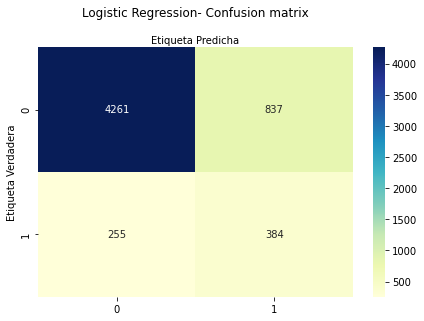

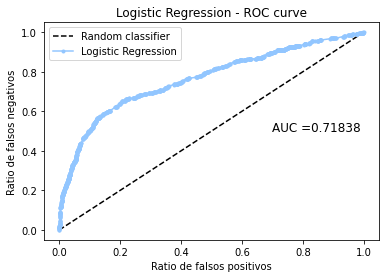

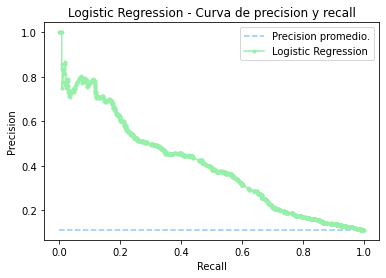

Random Forest - Classification report ==
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      5098
           1       0.32      0.59      0.42       639

    accuracy                           0.82      5737
   macro avg       0.63      0.72      0.65      5737
weighted avg       0.87      0.82      0.84      5737



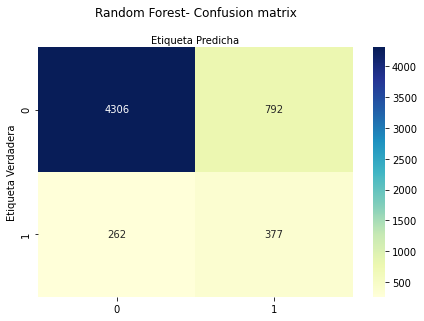

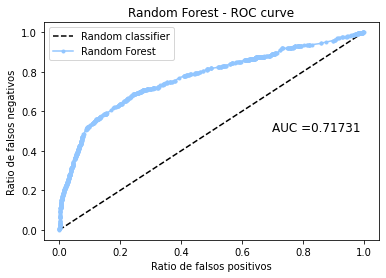

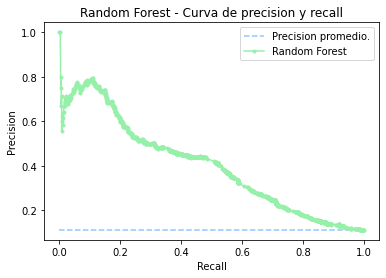

Gradient Boosting Classifier - Classification report ==
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5098
           1       0.34      0.57      0.43       639

    accuracy                           0.83      5737
   macro avg       0.64      0.72      0.67      5737
weighted avg       0.88      0.83      0.85      5737



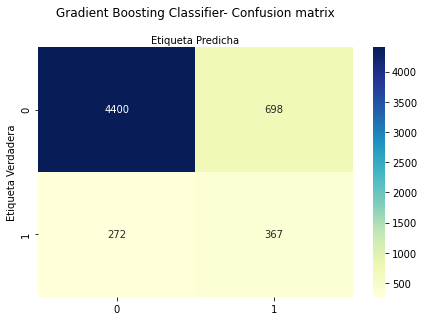

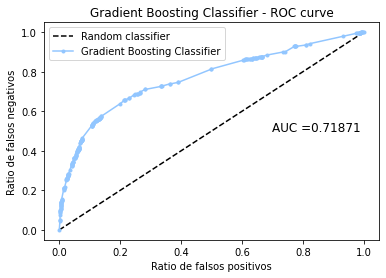

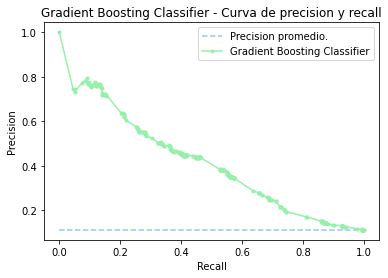

,Accuracy,Precision,Recall,AUC
Modelo,,,,
Logistic Regression,0.76517,0.3145,0.60094,0.71838
Random Forest,0.76948,0.3225,0.58998,0.71731
Gradient Boosting Classifier,0.76866,0.3446,0.57433,0.71871


In [242]:
modelos_caracteristicas = list()
for model, clf in [('Logistic Regression', cv_lr ) , ('Random Forest', cv_rf), ('Gradient Boosting Classifier' , cv_gbc)]:
    modelos_caracteristicas.append(caracteristicas_modelo(model, clf , X_v_reduce , y_v))

# Hacemos un DataFrame que compare y presente los modelos 
evaluacion_modelos = pd.DataFrame(modelos_caracteristicas).set_index('Modelo')
evaluacion_modelos

Para seleccionar el modelo definitivo debemos elegir una metrica. En este caso la metrica es RECALL, esto es así porque es una medida de la cantidad de casos positivos (clientes que quieren adquirir el producto) que el modelo puedo identificar. Elegí esta metrica porque considero que para el banco es más importante identificar a los clientes que Sí estarían dispuestos a adquirir el producto, frente a clasificar entre si los clientes adquirirían o no el producto(Es una logica similar a cuando queremos detectar fraude bancario).

Es por esto que el modelo elegido es una regresión logistica. 

In [259]:
print('Parametetros de regresion logistica')
type(cv_lr.best_params_)
pd.DataFrame(data = cv_lr.best_params_ , index = ['Logistic_regression'])

Parametetros de regresion logistica


,logisticregression__C,logisticregression__penalty,logisticregression__random_state
Logistic_regression,0.002783,none,0


# Conclusion 

En este ejercicio buscamos el desarrollo de un modelo predictivo que nos ayude a identificar aquellas personas que pueden hacer un deposito a plazo. Para el desarrollo del modelo se tuvieron en cuenta:

  * Tecnicas de feature selection como Feature Elimination combinado con un Cross validation y upsampling para balancear el data set

  * Tecnicas de seleccion de hiperparametros: Nuevamente se utilizo cross validation, así como tambien una tecnica mas sofisticada de Upsampleo llamada SMOTE para prevenir el overfiting cuando se balancean las clases.
  
  *Por ultimo se eligio el mejor modelo posible entre los 3 candidatos finales, teniendo en cuenta el desempeño en Recall.

Finalmente, como resultado obtuvimos un modelo Logistico con los siguientes hiperparametros :

  * C : 0.002783
  * Penalty : None .  Esto es esperable dado que ya se había realizado un proceso de feature seleccion por ende regularizar el Dataset no era necesario


El cual obtuvo un Recall 60% superando en un 2% al segundo modelo un Random Forest.